In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

ee.Initialize()


In [2]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied, currently works for 2000 - 2018
3) Scale (optional): Resolution at which to perform analysis (if not specified, calculated automatically in EE)
4) Satellites / datasets: Queried from Earth Engine, defined in data[sat1...] 
'''

##### AREA #####

# CV
cv = gp.read_file("../shape/cv.shp")
cv_km2 = round(cv.area[0] * 10, 2)* 1000

# HUC 4s draining to the CV 
ssjt = gp.read_file("../shape/cv_hu6.shp")
ssjt2 = ssjt.geometry.simplify(0.1) # This reduces the # of geometries submitted to EE and makes things run mucho faster 
lls = ssjt2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)

# Get the area of the ssjt wshed 
s1 = gp.read_file("../shape/1804_4.shp")
s2 = gp.read_file("../shape/1803_4.shp")
s3 = gp.read_file("../shape/1802_4.shp")
sa_km3 = unary_union([s1.geometry[0], s2.geometry[0], s3.geometry[0]]).area * 10000

##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)


In [3]:
# Read and format data 

In [4]:
# Wells data (processed by zihan using Faunt 2009 SY values )

wells = pd.read_csv("../data/wells_ds_faunt_sy.csv")
wells.month = wells.month.astype(str)
wells.year = wells.year.astype(str)
wells.month = wells.month.str.zfill(2)

wells['Date'] = pd.to_datetime(wells.year + wells.month , format="%Y%m") + MonthEnd(1)
wells.index = wells.Date
wells.drop(['Date'], axis =1, inplace = True)

wells['ds_km3'] = wells[wells.columns[-1]] * 50000 * 1e-5

In [5]:
# RS data 
cvdf = pd.read_csv("../data/all_data_cv.csv")

# Initialize the datetime columns
cvdf['dt'] = pd.to_datetime(cvdf[cvdf.columns[0]])
cvdf = cvdf.set_index(pd.to_datetime(cvdf[cvdf.columns[0]]))
cvdf.drop(["dt"],axis = 1, inplace = True)

# Chop off the first n rows of nodata
cvdf = cvdf.iloc[327:]

In [8]:
# Grace data

grace = pd.read_csv("../data/grace_argus.csv")

# Initialize the datetime columns
grace['dt'] = pd.to_datetime(grace[grace.columns[0]])
grace = grace.set_index(pd.to_datetime(grace[grace.columns[0]]))
grace.drop(["dt"],axis = 1, inplace = True)

# Subtract reservoir storage and soil moisture from grace 
grace['adj'] = grace.grace_mean[1:] - cvdf.soil_moisture.diff()[1:] - cvdf.res_s.diff()[1:]

In [9]:
# Calc the balance
cvdf['ds'] = cvdf.p_mean - cvdf.et_mean + cvdf.runoff - cvdf.q_out + cvdf.q_in - cvdf.soil_moisture.diff() -cvdf.res_s.diff()

In [10]:
df = cvdf.copy()

In [11]:
# Plot 

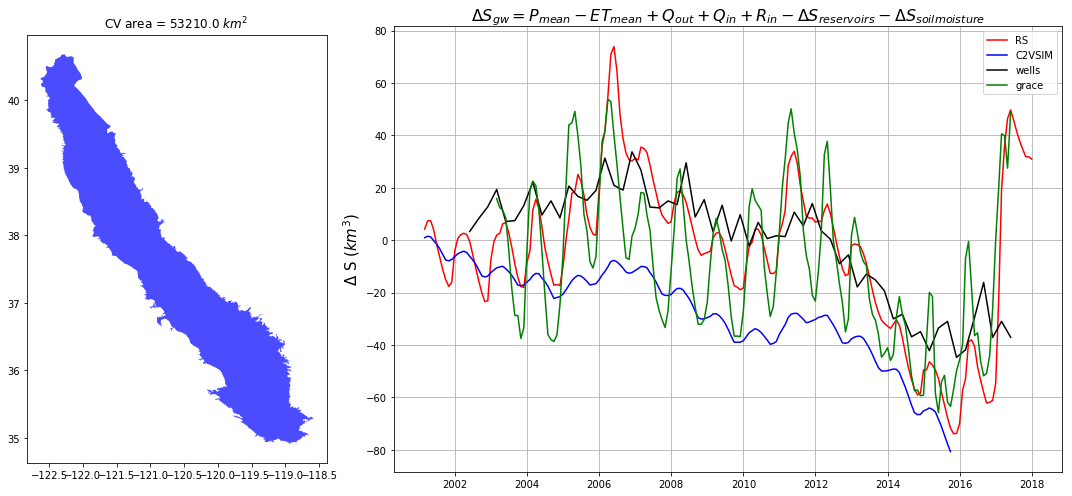

In [12]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps

axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("CV area = {} $km^2$ ".format(round(cv_km2, 3)))

axes_4 = plt.subplot(G[0:2, 1:])

axes_4.set_title("$\Delta S_{gw} = P_{mean} - ET_{mean} + Q_{out} + Q_{in} + R_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)
axes_4.plot(df.index, np.cumsum(df.ds), color="red", label = "RS")
axes_4.plot(df.index[1:], np.cumsum(df.s.diff()[1:]), color="blue", label = "C2VSIM")
axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells")
axes_4.plot(grace.index, grace.adj, color="green", label = "grace")

axes_4.set_ylabel('$\Delta$ S ($km^3$)', size = 15) 
axes_4.legend()

plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Ensemble ET 

In [14]:
et_results = []

for i in [df.modis, df.gmet_eto, df.gmet_etr, df.fldas, df.terraclimate, df.et_mean]:
    ds = df.p_mean - i - df.q_out + df.q_in + df.runoff - df.soil_moisture.diff() - df.res_s.diff()

    ds[0] = 0
    et_results.append(ds)
    
results = pd.concat(et_results, axis = 1)
results['avg'] = results.mean(axis = 1)
results['avg'][0] = 0

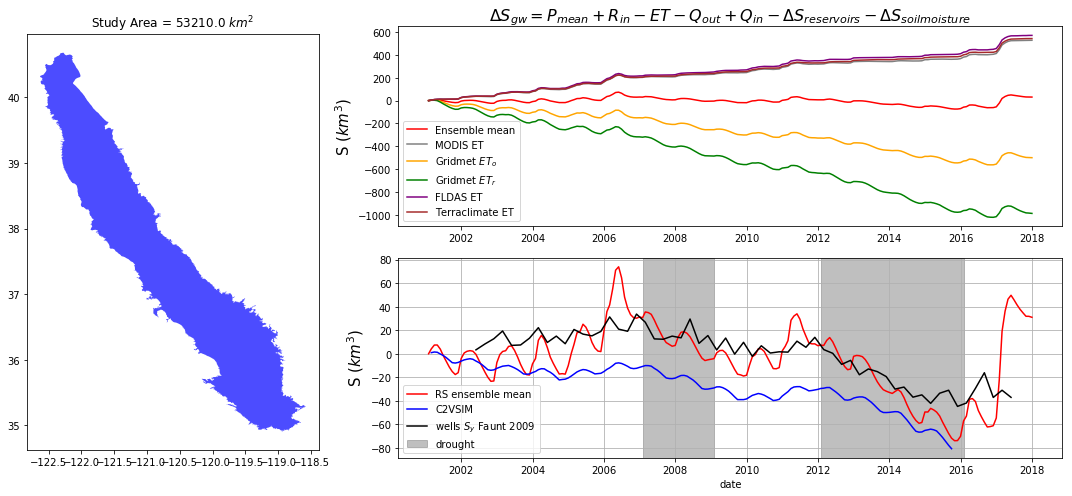

In [15]:
plt.figure(figsize=(15, 7))

G = gridspec.GridSpec(2, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax=axes_1, color = "blue", alpha = 0.7)
axes_1.set_title("Study Area = {} $km^2$".format(cv_km2))

a0 = plt.subplot(G[0, 1:])
a0.set_title("$\Delta S_{gw} = P_{mean} + R_{in} - ET - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$", size = 16)
a0.plot(results.index, np.cumsum(results.avg), color = "red", label = "Ensemble mean")
a0.plot(results.index, np.cumsum(results[0]), color = "gray", label = "MODIS ET")
a0.plot(results.index, np.cumsum(results[1]), color = "orange", label = "Gridmet $ET_o$")
a0.plot(results.index, np.cumsum(results[2]), color = "green", label = "Gridmet $ET_r$")
a0.plot(results.index, np.cumsum(results[3]), color  = "purple", label = "FLDAS ET")
a0.plot(results.index, np.cumsum(results[4]), color = "brown", label = "Terraclimate ET")
a0.set_ylabel('S ($km^3$)', size = 15) 
a0.legend()

axes_4 = plt.subplot(G[1, 1:])
axes_4.plot(results.index, np.cumsum(results.avg), color="red", label = "RS ensemble mean")
axes_4.plot(df.index[1:], np.cumsum(df.s.diff()[1:]), color="blue", label = "C2VSIM")
axes_4.axvspan(results.index[72], results.index[96], alpha=0.5, color='gray', label = "drought")
axes_4.axvspan(results.index[132], results.index[180], alpha=0.5, color='gray')
axes_4.plot(wells.index, wells.ds_km3, color="black", label = "wells $S_y$ Faunt 2009")

axes_4.set_ylabel('S ($km^3$)', size = 15) 
axes_4.set_xlabel('date')
axes_4.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

## $\Delta S_{gw} = P_{mean} + R_{in} - ET - Q_{out} + Q_{in} - \Delta S_{reservoirs} - \Delta S_{soil moisture}$